# Gaussian Mixture State Projection: Applied to Delayed Feedback Reward Recovery

Our aim is to carry out RL tasks when rewards are delayed (aggregate, and anonymous), using linear function approximation.
To solve this problem, we aim to project both large discrete states and continuous states into basis vectors.


In this notebook, we explore using Gaussian Mixutres (GM) as basis representations.
The GM is fitted using expectation maximization (EM).

Having tested the concept of random data, we turn to some actual environments to see how the method fairs.
We compare environments with both discrete and continuous states, as well as singular (e.g. -1 for every step) and multiple rewards.


Specifically, we will test the problem of recovering rewards for state-actions using GM as state representations.

In [1]:
from typing import Any, Mapping

In [2]:
# example of fitting a gaussian mixture model with expectation maximization
import gymnasium as gym
import numpy as np
import pandas as pd
from scipy import linalg, stats
from sklearn import mixture, model_selection

In [3]:
from rlplg.environments import gridworld, redgreen

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
def mv_normal(mu, eigenvalues):
    dim = len(mu)
    # ortho matrix
    ortho_matrix = stats.ortho_group.rvs(dim)
    # cov matrix; dim x dim
    cov = np.matmul(ortho_matrix, np.matmul(np.diag(eigenvalues), ortho_matrix.T))
    return stats.multivariate_normal(mu, cov)

In [6]:
def high_dim_data(dim: int, num_samples: int):
    mu = [np.random.rand()*np.random.randint(1, 100) for _ in range(dim)]
    eigenvalues = [np.random.rand()*np.random.randint(1, 1000) for _ in range(dim)]
    normal_dist = mv_normal(mu=mu, eigenvalues=eigenvalues)
    return normal_dist.rvs(size=num_samples)

In [7]:
def high_dim_mixture(X, num_components: int):
    # generate a sample
    # fit model
    model = mixture.GaussianMixture(
        n_components=num_components, init_params="k-means++", max_iter=1000
    )
    model.fit(X)
    return model

In [8]:
def solve_least_squares(
    matrix: np.ndarray, rhs: np.ndarray
) -> np.ndarray:
    try:
        solution, _, _, _ = linalg.lstsq(a=matrix, b=rhs, lapack_driver="gelsy")
        return solution  # type: ignore
    except linalg.LinAlgError as err:
        # the computation failed, likely due to the matix being unsuitable (no solution).
        raise ValueError("Failed to solve linear system") from err

In [9]:
def rmse(v_pred: np.ndarray, v_true: np.ndarray, axis: int):
    if np.shape(v_pred) != np.shape(v_true):
        raise ValueError(
            f"Tensors have different shapes: {np.shape(v_pred)} != {np.shape(v_true)}"
        )
    return np.sqrt(
        np.sum(np.power(v_pred - v_true, 2.0), axis=axis) / np.shape(v_pred)[axis]
    )

## Random Data

In [10]:
X = high_dim_data(dim=2, num_samples=100_000)
y = X[:,0]*0.1 + X[:,1]*2 + 0.5

In [11]:
def random_data_rewards(X, y, delay: int, sample_size: int):
    # TODO: test dynamic delay
    mask = np.random.choice(len(X), (sample_size, delay))
    samples = np.sum(X[mask], axis=1) # batch x delay x dim -> batch x dim
    rewards = np.sum(y[mask], axis=1) # batch x delay -> batch
    return samples, rewards

In [12]:
X_delay, y_delay = random_data_rewards(X, y, delay=3, sample_size=10_000)

In [13]:
sol = solve_least_squares(X_delay, y_delay)

In [14]:
sol

array([0.10654046, 2.02021491])

In [15]:
X

array([[  8.8568464 ,  -2.92202085],
       [-21.5981353 ,  24.9662697 ],
       [-15.93155109,  10.51622435],
       ...,
       [ -2.87111932,  -2.72777746],
       [  3.81625027,  15.87354447],
       [-34.17144773,  21.55469772]])

In [16]:
yhat = np.matmul(X, sol)

In [17]:
rmse(v_pred=yhat, v_true=y, axis=0)

0.4125294897054644

In [18]:
y[:10], yhat[:10]

(array([ -4.45835706,  48.27272587,  19.93929359,  30.57897724,
        -33.82281674,  66.67987269, -20.62201717,  22.21445547,
         52.68928503,  13.49950946]),
 array([ -4.95949762,  48.13615502,  19.54767848,  30.27850202,
        -34.48002262,  67.03222177, -21.24121374,  21.98860125,
         52.67246127,  13.09383392]))

## Gym Env

In [19]:
def collection_traj_data(env, steps: int):
    obs, _ = env.reset()
    step = 0
    buffer = []
    while step < steps:
        action = env.action_space.sample()
        next_obs, rew, term, trunc, _,  = env.step(action)
        step += 1
        buffer.append((obs, action, rew))
        obs = next_obs
        if term or trunc:
            obs, _ = env.reset()
    return buffer

In [20]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [21]:
def gm_proj(buffer, param_grid):
    obs = np.stack([example[0] for example in buffer])
    grid_search = model_selection.GridSearchCV(
        mixture.GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )
    return grid_search.fit(obs)

In [22]:
def delay_reward_data(buffer, proj_model, delay: int, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    obs_basis = proj_model.predict_proba(obs)
    # repr: (m1,a1)(m2,a1)..
    mdim = obs_basis.shape[1] * len(np.unique(action))
    num_components = obs_basis.shape[1]

    # build samples
    mask = np.random.choice(len(obs_basis), (sample_size, delay))
    delayed_obs = obs_basis[mask] # batch x delay x dim
    delayed_act = action[mask]
    delayed_rew = np.sum(reward[mask], axis=1) # batch x delay -> batch    
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        for j in range(delay):
            c = num_components*delayed_act[i][j]
            rhat_matrix[i,c:c+num_components] += delayed_obs[i][j]

    return rhat_matrix, delayed_rew

In [23]:
def proj_obs_to_rwest_vec(buffer, proj_model, sample_size: int):
    obs = np.stack([example[0] for example in buffer])
    action = np.stack([example[1] for example in buffer])
    reward = np.stack([example[2] for example in buffer])
    
    obs_basis = proj_model.predict_proba(obs)
    # repr: (m1,a1)(m2,a1)..
    mdim = obs_basis.shape[1] * len(np.unique(action))
    num_components = obs_basis.shape[1]

    # build samples
    mask = np.random.choice(len(obs_basis), sample_size)
    delayed_obs = obs_basis[mask] # batch x dim
    delayed_act = action[mask] # batch
    delayed_rew = reward[mask] # batch
    
    rhat_matrix = np.zeros(shape=(len(delayed_obs), mdim))
    
    for i in range(len(delayed_obs)):
        c = num_components*delayed_act[i]
        rhat_matrix[i,c:c+num_components] += delayed_obs[i]
    return rhat_matrix, delayed_rew

In [24]:
def solve_rwe(env: gym.Env, num_steps: int, sample_size: int, delay: int, param_grid: Mapping[str, Any]):
    buffer = collection_traj_data(env, steps=num_steps)
    gmp = gm_proj(buffer, param_grid=param_grid)
    print(gmp.best_estimator_)
    Xd, yd = delay_reward_data(buffer, gmp, delay=delay, sample_size=sample_size)
    return buffer, gmp, solve_least_squares(Xd, yd)

In [25]:
def rwe_scatterplot(v_pred, v_true):
    _, ax = plt.subplots(figsize=(6, 6))
    df = pd.DataFrame({
        "x": v_pred,
        "y": v_true,
        "size": np.abs(v_pred - v_true)
    })
    sns.scatterplot(
        df, x="x", y="y", size="size", hue="size", s=5, color=".15"
    )
    # sns.histplot(x=v_pred, y=v_true, bins=50, cmap="mako")
    # sns.kdeplot(x=v_pred, y=v_true, levels=5, color="w")
    ax.set_xlabel("yhat")
    ax.set_ylabel("ytrue")
    ax.set_title("Reward Estimation")

### Moutain Car

In [26]:
mc_env = gym.make("MountainCar-v0")
mc_buffer, mc_gmp, mc_sol = solve_rwe(
    mc_env,
    num_steps=100_000, 
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(2, 8),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(covariance_type='diag', n_components=3)


In [27]:
len(mc_buffer)

100000

In [28]:
mc_buffer[0]

(array([-0.53878933,  0.        ], dtype=float32), 0, -1.0)

In [29]:
mc_gmp

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(2, 8)},
             scoring=<function gmm_bic_score at 0x14787b560>)

In [30]:
mc_gmp.best_estimator_

GaussianMixture(covariance_type='diag', n_components=3)

In [31]:
mc_sol

array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [32]:
mc_eval_X, mc_eval_y = proj_obs_to_rwest_vec(mc_buffer, mc_gmp, sample_size=10_000)

In [33]:
mc_eval_y

array([-1., -1., -1., ..., -1., -1., -1.])

In [34]:
np.matmul(mc_eval_X, mc_sol)

array([-1., -1., -1., ..., -1., -1., -1.])

In [35]:
rmse(
    v_pred=np.matmul(mc_eval_X, mc_sol),   
    v_true=mc_eval_y,
    axis=0
)

6.311576395755961e-16

The predicted reward for every state action pair is -1 which is correct.
Though for this problem, it's a constant for every state (except the terminal state, for which the reward is always zero).

### Grid World (Different Rewards)

In [36]:
class GW2D(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self, obs):
        # assume one exit
        # Option 1: 3D grid with agent, cliffs, exit (flattened)
        # Option 2: Deltas between agent and cliffs, and exit
        # TODO: experiment with different options
        # This is option 2
        return np.stack(
            [np.array(obs["agent"]) - np.array(obs["exits"][0])]
            + [np.array(obs["agent"]) - np.array(cliff) for cliff in obs["cliffs"]]
        ).flatten()

In [62]:
size, cliffs, exits, start = gridworld.parse_grid_from_text(
    ["oooooooooooo", "oooooooooooo", "oooooooooooo", "sxxxxxxxxxxg"]
)
print(size, cliffs, exits, start)
gw_env = GW2D(gridworld.GridWorld(size, cliffs, exits, start))
gw_buffer, gw_gmp, gw_sol = solve_rwe(
    gw_env,
    num_steps=100_000,
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(15, 20),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

(4, 12) [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10)] [(3, 11)] (3, 0)
GaussianMixture(n_components=19)


In [63]:
gw_sol

array([  -1.00532282,   -1.0014816 ,   -1.01899081,   -0.99924857,
         -1.00661212,   -1.00578567,   -1.01216437,   -1.00874501,
         -1.03928747,   -1.00784689,   -1.01436238,   -1.00241742,
         -1.00833348,   -1.01318299,   -1.00807709,   -1.00708106,
         -0.99671931,   -1.01532991,   -0.98366217,   -1.01495359,
         -1.00435072,   -1.01471459,   -0.99190217,   -1.01641567,
       -100.01657836,   -1.00577584,   -1.00715713,   -1.08467179,
         -1.02831   ,   -1.02019384,   -1.01568779,   -1.00128816,
         -0.99691911,   -1.02069924,   -1.00937545,   -1.00590848,
         -1.00431558,   -0.98490754,   -1.00594123,   -1.01986301,
         -1.00725308,   -1.08958713,   -1.01418702,   -1.00278602,
         -1.01234355,   -1.0187583 ,   -0.98928281,   -1.01633777,
         -1.01625818,   -1.02998115,   -1.00466817,   -1.02919994,
         -1.01571699,   -0.99762462,   -0.41448444,   -1.01186299,
         -0.98820123,   -1.00999821,   -1.00477388,   -1.00201

In [64]:
gw_gmp

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(15, 20)},
             scoring=<function gmm_bic_score at 0x14787b560>)

In [65]:
gw_eval_X, gw_eval_y = proj_obs_to_rwest_vec(gw_buffer, gw_gmp, sample_size=10_000)

In [66]:
rmse(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y,
    axis=0
)

1.3905541384608051

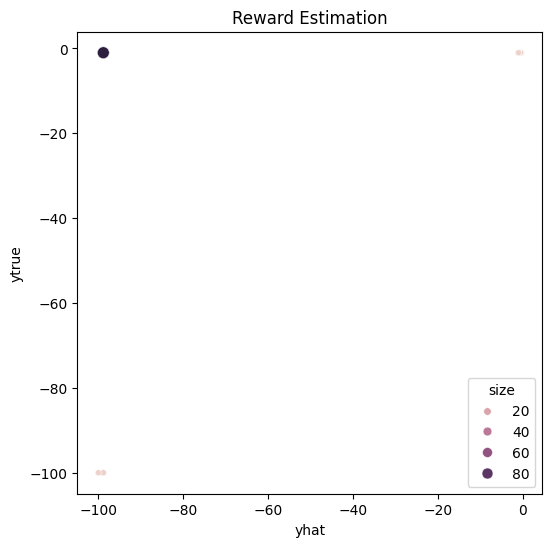

In [68]:
rwe_scatterplot(
    v_pred=np.matmul(gw_eval_X, gw_sol), 
    v_true=gw_eval_y
)

In [69]:
gw_eval_X.shape, gw_eval_y.shape

((10000, 76), (10000,))

In [70]:
np.unique(np.around(np.matmul(gw_eval_X, gw_sol), 2))

array([-100.02, -100.01, -100.  ,  -98.86,   -1.09,   -1.08,   -1.06,
         -1.04,   -1.03,   -1.02,   -1.01,   -1.  ,   -0.99,   -0.98,
         -0.65,   -0.53,   -0.42,   -0.41])

For this environment with discrete states, the predicted rewards for the basis states can either over or understimated, with some error non-negible error.

### RedGreen

In [46]:
class RG2D(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(shape=(2,), low=-np.inf, high=np.inf)

    def observation(self, obs):
        # assume one exit
        # Option 1: 3D grid with agent, cliffs, exit (flattened)
        # Option 2: Deltas between agent and cliffs, and exit
        # TODO: experiment with different options
        # This is option 2
        return np.array([obs["pos"], len(obs["cure_sequence"])])

In [47]:
rg_env = RG2D(redgreen.RedGreenSeq(["red", "green", "red", "green", "wait", "green"]))
rg_buffer, rg_gmp, rg_sol = solve_rwe(
    rg_env, 
    num_steps=100_000, 
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(2, 10),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (6

GaussianMixture(covariance_type='tied', n_components=6)


In [48]:
rg_sol

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1.])

In [49]:
rg_eval_X, rg_eval_y = proj_obs_to_rwest_vec(rg_buffer, rg_gmp, sample_size=10_000)

In [50]:
rmse(
    v_pred=np.matmul(rg_eval_X, rg_sol), 
    v_true=rg_eval_y,
    axis=0
)

3.2114591854547243e-15

When multiplied with the probibility distribution over basis states, the above solution also yields rewards of -1 for every state.

### Lunda Lander

In [51]:
lunar_env = gym.make("LunarLander-v3")
lunar_buffer, lunar_gmp, lunar_sol = solve_rwe(
    lunar_env,
    num_steps=100_000,
    sample_size=10_000,
    delay=2,
    param_grid={
        "n_components": range(2, 6),
        "covariance_type": ["spherical", "tied", "diag", "full"],
    }
)

GaussianMixture(n_components=5)


In [52]:
lunar_sol

array([-16.63296117,  -0.78494146, -22.02365654,  -1.64600832,
       -14.61208464, -23.87365575,  -0.82814383, -22.6022666 ,
        -1.52753964,  -6.06382046, -18.51152588,  -0.19957736,
       -19.85096477,   0.14727319,  -7.86639819, -31.45967821,
        -0.80449144, -18.4075267 ,  -2.00524177,  -9.4014698 ])

In [53]:
lunar_eval_X, lunar_eval_y = proj_obs_to_rwest_vec(lunar_buffer, lunar_gmp, sample_size=10_000)

In [54]:
lunar_eval_X.shape, lunar_eval_y.shape

((10000, 20), (10000,))

In [55]:
np.matmul(lunar_eval_X, lunar_sol)

array([-1.52753964, -1.52753965, -1.64600832, ...,  0.14727319,
       -0.80509312, -0.17877943])

In [56]:
lunar_eval_y

array([-4.74613742, -0.02614748, -0.94566962, ..., -0.85696273,
       -2.9756064 , -4.21009223])

/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/guilherme/Code/research.phd/drmdp-fnapprox/.venv/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this war

<Axes: xlabel='reward', ylabel='Count'>

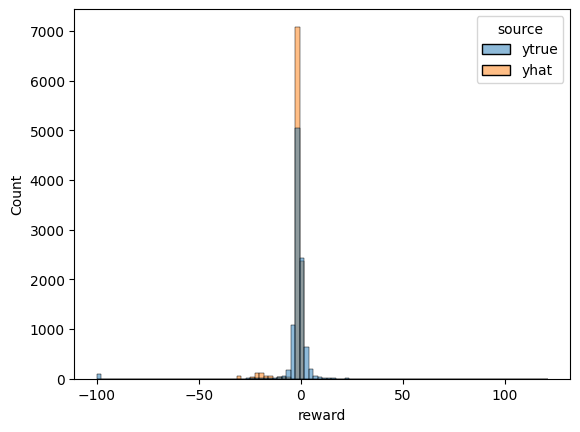

In [57]:
sns.histplot(
    pd.DataFrame({
        "reward": lunar_eval_y.tolist() + np.matmul(lunar_eval_X, lunar_sol).tolist(),
        "source": ["ytrue"]*len(lunar_eval_y) + ["yhat"]*len(lunar_eval_X)
    }),
    x="reward",
    hue="source",
    bins=100
)

In [58]:
rmse(
    v_pred=np.matmul(lunar_eval_X, lunar_sol), 
    v_true=gw_eval_y,
    axis=0
)

9.820190268740555

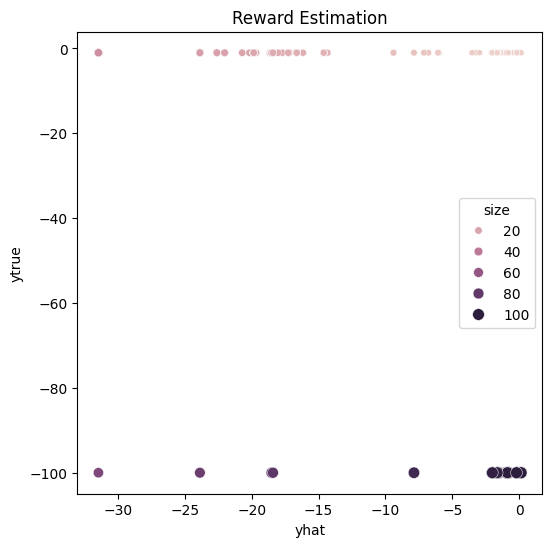

In [59]:
rwe_scatterplot(
    v_pred=np.matmul(lunar_eval_X, lunar_sol),   
    v_true=gw_eval_y
)

Recovering rewards on this problem is challenging because the rewards are non-linear, as they:

  - Depende on `sqrt` and `power` operations on certain dimensions of the state
  - Are linearly translated based on certain state conditions as well.

Modeling this kind of reward requires non-linear functions, so we skip it for now.

## Conclusions

  - Using Gaussian Mixtures can be effective in cases where the rewards are constans, since the state is made up of probabilities to each basis dimension summing up to one, i.e. $\sum_{i}c_{i} = 1$, where $c$ is a component of the GM mixture. Thus, the linear problem is trivial to sum with LEAST
  - But they can be more challenging when given discrete states with different outcomes. This "clustering" of states approaches can group states with very diverging reward values, yielding a value that over and underestimates the true rewards of each state in the cluster.